# Split dataset

In [ ]:
# The following code further divides the images of training and annotations
# into test and training dataset
import os, random, shutil

'''

# from fileDir to tarDir
def moveFile(fileDir, tarDir):
    pathDir = os.listdir(fileDir)    
    filenumber=len(pathDir)
    # Proportion of images extracted
    rate=0.1    
    picknumber=int(filenumber*rate) 
    sample = random.sample(pathDir, picknumber)  
    print (sample)
    for name in sample:
            shutil.move(fileDir+name, tarDir+name)
    return



if __name__ == '__main__':

    fileDir = 'D:/DL/ADEChallengeData2016/images/training/'    
    tarDir = 'D:/DL/ADEChallengeData2016/images/test/'    
    annTrain = 'D:/DL/ADEChallengeData2016/annotations/training/'
    annTar = 'D:/DL/ADEChallengeData2016/annotations/test/'
    #moveFile(fileDir, tarDir)

    g = os.walk(r"D:/DL/ADEChallengeData2016/images/test/")

    for path,dir_list,file_list in g:
        for file_name in file_list:
            finalPath = os.path.join(path, file_name)
            #print(finalPath)
            imageName = file_name.replace('jpg' , 'png')
            #print(imageName)
            shutil.move(annTrain+imageName, annTar+imageName)

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!unzip -uq "drive/My Drive/DL-ADEChallengeData2016.zip" -d "drive/My Drive/DL"
drive.flush_and_unmount()
print("done")
'''

'\n\n# from fileDir to tarDir\ndef moveFile(fileDir, tarDir):\n    pathDir = os.listdir(fileDir)    \n    filenumber=len(pathDir)\n    # Proportion of images extracted\n    rate=0.1    \n    picknumber=int(filenumber*rate) \n    sample = random.sample(pathDir, picknumber)  \n    print (sample)\n    for name in sample:\n            shutil.move(fileDir+name, tarDir+name)\n    return\n\n\n\nif __name__ == \'__main__\':\n\n    fileDir = \'D:/DL/ADEChallengeData2016/images/training/\'    \n    tarDir = \'D:/DL/ADEChallengeData2016/images/test/\'    \n    annTrain = \'D:/DL/ADEChallengeData2016/annotations/training/\'\n    annTar = \'D:/DL/ADEChallengeData2016/annotations/test/\'\n    #moveFile(fileDir, tarDir)\n\n    g = os.walk(r"D:/DL/ADEChallengeData2016/images/test/")\n\n    for path,dir_list,file_list in g:\n        for file_name in file_list:\n            finalPath = os.path.join(path, file_name)\n            #print(finalPath)\n            imageName = file_name.replace(\'jpg\' , \'png

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 

from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import glob

In [ ]:
folder_path = "drive/My Drive/DL/DL-ADEChallengeData2016/"

In [ ]:
import torch.utils.data as data
import glob
import numpy as np
def get_edge_annotation(img):
  laplacian_kernel = PIL.ImageFilter.Kernel(size=(3, 3), kernel=(0, 1, 0, 1, -4, 1, 0, 1, 0), scale=1, offset=0)
  return img.filter(laplacian_kernel)

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, split="training"):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'images', split, '*.jpg')))
        self.mask_files =  sorted(glob.glob(os.path.join(folder_path,'annotations', split, '*.png')))

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = PIL.Image.open(img_path)
        mask = PIL.Image.open(mask_path)

        image = np.asarray(transforms.Resize([512,512])(image))
        image = transforms.ToTensor()(np.array(image))
        mask = transforms.Resize([512,512])(mask)
        edge_mask = get_edge_annotation(mask)
        mask = np.asarray(mask).astype(np.int64)
        edge_mask = np.asarray(edge_mask).astype(np.int64)
        edge_mask = np.where(edge_mask > 0, 1, 0)
        return image, torch.from_numpy(mask),torch.from_numpy(edge_mask)

    def __len__(self):
        return len(self.img_files)//2
     

In [ ]:
train_data = DataLoaderSegmentation(folder_path)
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=False, num_workers = 4)
print(len(train_data_loader))  
validation_data = DataLoaderSegmentation(folder_path, split="validation")
validation_data_loader = DataLoader(validation_data, batch_size=8, shuffle=False, num_workers = 4)
print(len(validation_data_loader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


1137
125


# Show sample images

In [ ]:
test_data = DataLoaderSegmentation(folder_path, split="test")
test_data_loader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers = 4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
img, seg, edge = next(iter(test_data_loader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
Mask = torch.tensor([
        [120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50], [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7], [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3], [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
        [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220], [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
        [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255], [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
        [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153], [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
        [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0], [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
        [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255], [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
        [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0], [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
        [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255], [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
        [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20], [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
        [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255], [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
        [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0], [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
        [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255], [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
        [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160], [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
        [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0], [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
        [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255], [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
        [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255], [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
        [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194], [102, 255, 0], [92, 0, 255], [30, 180, 120]
])
def visualize_first_n(batch_img, batch_seg, n):
    fig, ax = plt.subplots(1, n, figsize=(20,10))
    i=0
    for ax in ax.ravel():
      # break when no more axes left
      if ax is None:
          break
      ax.imshow(batch_img[i,:,:,:].permute((1,2,0)))
      ax.axis('off')
      ax.set_title('image {}'.format(i+1))
      i += 1

    fig, ax = plt.subplots(1, n, figsize=(20,10))
    i=0
    for ax in ax.ravel():
      if ax is None:
          break
      seg_mask = np.zeros((512,512,3))
      for k in range(512):
        for j  in range(512):
          seg_mask[k,j,:] = Mask[batch_seg[i,k,j].item()]/255.0
      ax.imshow(seg_mask)
      ax.axis('off')
      ax.set_title('annotation {}'.format(i+1))
      i += 1

def vis_with_edge(batch_img, batch_seg, batch_edge, n):
    visualize_first_n(batch_img, batch_seg, n)
    fig, ax = plt.subplots(1, n, figsize=(20,10))
    i=0
    for ax in ax.ravel():
      if ax is None:
          break
      ax.imshow(batch_edge[i,:,:])
      ax.axis('off')
      ax.set_title('edge {}'.format(i+1))
      i += 1    


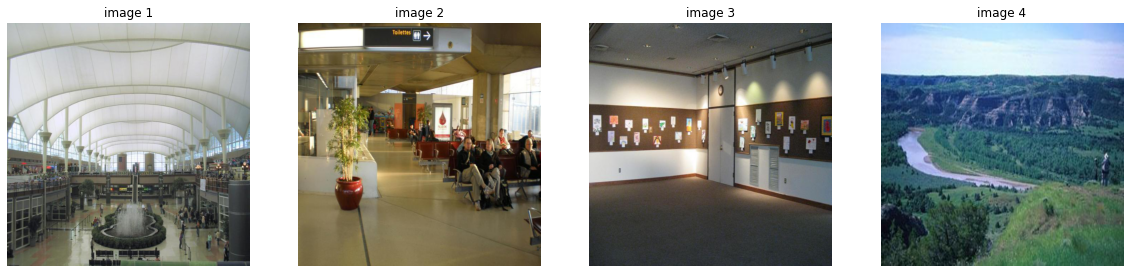

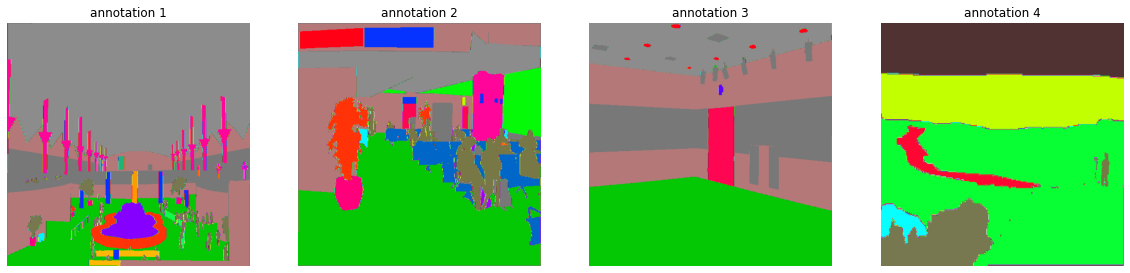

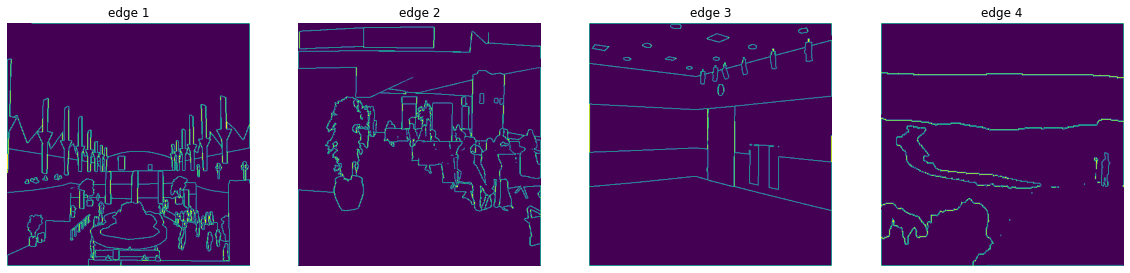

In [ ]:
vis_with_edge(img, seg, edge, 4)

# Model2

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from torch import cat, nn, squeeze
import cv2
import numpy as np
import torchvision
import warnings
warnings.filterwarnings("ignore")

def get_encoder(model, pretrained=True):
    if model == "resnet18":
        encoder = torchvision.models.resnet18(pretrained=pretrained)
    elif model == "resnet34":
        encoder = torchvision.models.resnet34(pretrained=pretrained)
    elif model == "resnet50":
        encoder = torchvision.models.resnet50(pretrained=pretrained)
    elif model == "resnext50":
        encoder = torchvision.models.resnext50_32x4d(pretrained=pretrained)
    elif model == "resnext101":
        encoder = torchvision.models.resnext101_32x8d(pretrained=pretrained)
        
    if model in ["resnet18", "resnet34"]: 
        model = "resnet18-34"
    else: 
        model = "resnet50-101"
        
    filters_dict = {
        "resnet18-34": [512, 512, 256, 128, 64],
        "resnet50-101": [2048, 2048, 1024, 512, 256]
    }

    return encoder, filters_dict[model]

class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int, activate=True, batch_norm=False):
        super(ConvRelu, self).__init__()
        self.activate = activate
        self.batch_norm = batch_norm
        self.bn = nn.BatchNorm2d(out)
        self.conv = nn.Conv2d(in_, out, 3, padding=1)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        if self.activate:
            x = self.activation(x)
        return x

class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels: int, num_filters: int, batch_norm=True):
        super(ResidualBlock, self).__init__()
        self.batch_norm = batch_norm
        self.bn = nn.BatchNorm2d(num_filters)
        self.activation = nn.ReLU(inplace=True)
        self.conv_block = ConvRelu(in_channels, num_filters, activate=True, batch_norm=True)
        self.conv_block_na = ConvRelu(in_channels, num_filters, activate=False, batch_norm=True)
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, inp):
        x = self.conv_block(inp)
        x = self.conv_block_na(x)
        if self.batch_norm:
            x = self.bn(x)
        x = x.add(inp)
        x = self.activation(x)
        return x

class DecoderBlockResNet(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels, res_blocks_dec=False):
        super(DecoderBlockResNet, self).__init__()
        self.in_channels = in_channels
        self.res_blocks_dec = res_blocks_dec

        layers_list = [ConvRelu(in_channels, middle_channels, activate=True, batch_norm=False)]
        
        if self.res_blocks_dec:
            layers_list.append(ResidualBlock(middle_channels, middle_channels, batch_norm=True))
        
        layers_list.append(nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2, padding=1))
        if not self.res_blocks_dec:
            layers_list.append(nn.ReLU(inplace=True))
        
        self.block = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.block(x)

class UnetResNetEdge(nn.Module):

    def __init__(self, input_channels=3, num_classes=1, num_filters=32, res_blocks_dec=False,
                 Dropout=.2, encoder_name="resnet34", edge_encoder_name = "resnet18", pretrained=True):
        
        super().__init__()
        self.encoder, self.filters_dict = get_encoder(encoder_name, pretrained)
        # self.edge_encoder, self.filters_dict_edge = get_encoder(edge_encoder_name, pretrained)
        self.num_classes = num_classes
        self.Dropout = Dropout
        self.res_blocks_dec = res_blocks_dec
        self.input_channels = input_channels
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

        # build encoder for image
        self.conv1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.pool)
        self.conv2 = self.encoder.layer1
        self.conv3 = self.encoder.layer2
        self.conv4 = self.encoder.layer3
        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockResNet(self.filters_dict[0], num_filters * 8 * 2, 
                                         num_filters * 8, res_blocks_dec=False)
        self.dec5 = DecoderBlockResNet(self.filters_dict[1] + num_filters * 8, 
                                       num_filters * 8 * 2, num_filters * 8, res_blocks_dec=self.res_blocks_dec)    
        self.dec4 = DecoderBlockResNet(self.filters_dict[2] + num_filters * 8, 
                                       num_filters * 8 * 2, num_filters * 8, res_blocks_dec=self.res_blocks_dec)
        self.dec3 = DecoderBlockResNet(self.filters_dict[3] + num_filters * 8, 
                                       num_filters * 4 * 2, num_filters * 2, res_blocks_dec=self.res_blocks_dec)
        self.dec2 = DecoderBlockResNet(self.filters_dict[4] + num_filters * 2, 
                                       num_filters * 2 * 2, num_filters * 2 * 2, res_blocks_dec=self.res_blocks_dec)
        
        self.dec1 = DecoderBlockResNet(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, res_blocks_dec=False)
        self.dec0 = ConvRelu(num_filters, num_filters)

        # dropout layers
        self.dropout_2d = nn.Dropout2d(p=self.Dropout)
        self.edge_dropout_2d = nn.Dropout2d(p=self.Dropout)

        # the output layer for seg
        self.final_seg = nn.Conv2d(num_filters, num_classes, kernel_size=3, padding=1)
        
        # the output layer for edge
        self.final_edge = nn.Conv2d(num_filters, 1, kernel_size=3, padding=1)

        # the final output layer
        self.final = nn.Conv2d(152, num_classes, kernel_size = 3, padding = 1)
        

    def forward(self, x, z=None):
        
        # encode image
        conv1 = self.conv1(x)
        # torch.Size([2, 64, 128, 128])
        conv2 = self.dropout_2d(self.conv2(conv1))
        # torch.Size([2, 64, 128, 128])
        conv3 = self.dropout_2d(self.conv3(conv2))
        conv4 = self.dropout_2d(self.conv4(conv3))
        conv5 = self.dropout_2d(self.conv5(conv4))
        center = self.center(self.pool(conv5))
        
        # decoder 
        dec5 = self.dec5(cat([center, conv5], 1))
        dec4 = self.dec4(cat([dec5, conv4], 1))
        dec3 = self.dec3(cat([dec4, conv3], 1))
        dec2 = self.dec2(cat([dec3, conv2], 1))
        dec2 = self.dropout_2d(dec2)

        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1) 

        edge_pred = self.final_edge(dec0)
        # print("edge_pred: ", edge_pred.shape) edge_pred:  torch.Size([2, 1, 512, 512])

        # output segmentation result
        combined_cat = torch.cat([edge_pred, self.final_seg(dec0)], 1)
        # print("combined_cat: ", combined_cat.shape) combined_cat:  torch.Size([2, 152, 512, 512])

        return self.final(combined_cat), edge_pred # (torch.Size([2, 151, 512, 512]), torch.Size([2, 1, 512, 512]))

In [ ]:
class SegLossEdgeAttention(nn.Module):
    def __init__(self, num_classes, mode='train', edge_weight=0.3, seg_weight=0.7):
        super(SegLossEdgeAttention, self).__init__()
        self.num_classes = num_classes
        self.seg_loss = torch.nn.CrossEntropyLoss() # softmax with crossentropy
        self.edge_loss = torch.nn.BCEWithLogitsLoss() # sigmoid with crossentropy

        self.edge_weight = edge_weight
        self.seg_weight = seg_weight

    def forward(self, inputs, targets):
        seg_in, edge_in = inputs
        seg_mask, edge_mask = targets
        losses = {}

        losses['seg_loss'] = self.seg_weight * self.seg_loss(seg_in, seg_mask.long())
        losses['edge_loss'] = self.edge_weight * self.edge_loss(edge_in, edge_mask) * 20

        return losses

In [ ]:
# for updating training loss and validation loss 
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnetResNetEdge(encoder_name="resnet34", 
                           num_classes=151, 
                           input_channels=3, 
                           num_filters=32, 
                           Dropout=0.3).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
batch_size = 4
num_classes = 151
edge_weight = 0.3
seg_weight = 1
learning_rate = 0.001
best_loss = 1000
# initialize our defined seg loss
loss_function = SegLossEdgeAttention(num_classes, mode='train', edge_weight=edge_weight, seg_weight=seg_weight).to(device)
# initialize an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

def adjust_learning_rate(optimizer, epoch, learning_rate):
    learning_rate = learning_rate * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

In [ ]:
epoch_save_train_inf_for_colab = 5  
save_model_path_colab = "/content/drive/My Drive/DL/latest_model_A/"

In [ ]:
train_loss = []
val_loss = []
num_epoch = 40

for epoch in range(num_epoch):
    adjust_learning_rate(optimizer, epoch, learning_rate)
    print("-" * num_epoch)
    print(f"epoch {epoch + 1}/{num_epoch}")
    model.train()
    model = model.to(device)

    train_main_loss = AverageMeter()
    curr_iter = 0#curr_epoch * len(train_loader)

    batches = tqdm(train_data_loader, total=len(train_data_loader))
    for inputs, mask, edge in batches:
        inputs = inputs.type(torch.cuda.FloatTensor).to(device)
        mask = mask.type(torch.cuda.FloatTensor).to(device)
        edge = torch.unsqueeze(edge, 1)
        edge = edge.type(torch.cuda.FloatTensor).to(device)

        optimizer.zero_grad()

        seg_out, mask_out = model(inputs)
        loss = loss_function((seg_out, mask_out), (mask, edge))
        main_loss = loss['seg_loss']
        main_loss += loss['edge_loss']

        main_loss.backward()
        optimizer.step()
        train_main_loss.update(main_loss.item())
                
        curr_iter += 1
    train_loss.append(train_main_loss.avg)
    print(f"epoch {epoch + 1} average loss: {train_main_loss.avg:.4f}")

    model.eval()
    with torch.no_grad():
        val_loss = AverageMeter()
        iou_acc = 0

        batches = tqdm(validation_data_loader, total=len(validation_data_loader))

        for inputs, mask, edge in batches:

            inputs = inputs.type(torch.cuda.FloatTensor).to(device)
            mask = mask.type(torch.cuda.FloatTensor).to(device)
            edge = torch.unsqueeze(edge, 1)
            edge = edge.type(torch.cuda.FloatTensor).to(device)

            with torch.no_grad():
                seg_out, mask_out = model(inputs)

            loss = loss_function((seg_out, mask_out), (mask, edge))
            main_loss = loss['seg_loss']
            main_loss += loss['edge_loss']

            val_loss.update(main_loss.item())
        val_loss.append(val_loss.avg)      
        print(f"epoch {epoch + 1} average loss: {val_loss.avg:.4f}")

    # save the model if it has improvement
    if val_loss < best_loss:
      model_name = f"/content/drive/MyDrive/DL/unet_edge_model.pth"
      torch.save(model.state_dict(), model_name)
      print(f"Save {model_name}!")
      best_loss = val_loss

    if epoch > 30:
        epoch_save_train_inf_for_colab = 3
    if epoch % epoch_save_train_inf_for_colab == int(epoch_save_train_inf_for_colab-1):
        state = { 
                    'model': model.state_dict(), 
                    'optimizer':optimizer.state_dict(), 
                    'val_loss':val_loss,
                    'best_loss':best_loss,
                 
                    'train_main_loss':train_main_loss,
                    'best_loss':best_loss,
                    'train_loss':train_loss
                    }
        # save_model_path_colab="/content/drive/My Drive/colab notebooks/output/"   
        # save_model_path_colab_new=os.path.join(save_model_path_colab,
        #                                         f'{epoch}_{i:06}_loss{loss}.pt')
        torch.save(state,save_model_path_colab+"unet_edge_model.pth")
        print('save train model at ', save_model_path_colab+"unet_edge_model.pth","from colab")
  

----------------------------------------
epoch 1/40


  0%|          | 0/1137 [00:00<?, ?it/s]

epoch 1 average loss: 3.8560


  0%|          | 0/125 [00:00<?, ?it/s]

AttributeError: ignored

## Reload model

In [ ]:

'''
save_model_path_colab = "/content/drive/My Drive/DL_model_save/"
save_path = save_model_path_colab + "best_unet_model.pth"
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']

val_loss  = checkpoint['val_loss']
best_loss = checkpoint['best_loss']
best_metric_epoch = checkpoint['best_metric_epoch']
epoch_loss_values = checkpoint['epoch_loss_values']
val_loss_values = checkpoint['val_loss_values']

print("Finish epoch turn: {}, Epoch index: {}, Now val_loss：{:.4f} and best_loss：{:}".format(start_epoch+1,start_epoch,val_loss,best_loss))
'''

##Results

In [ ]:
# plot training loss and validation loss
import matplotlib.pyplot as plt
def plot_train_val_loss(epoch_loss_values, val_loss_values, file_name):
    plt.plot(np.arange(len(epoch_loss_values))+1, epoch_loss_values, label = "training")
    plt.xlabel("Epoch")
    # plt.ylabel("Training Cross-Entropy Loss")
    plt.plot(np.arange(len(val_loss_values))+1, val_loss_values, label = "validation")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    # plt.title("Validation")
    plt.legend()
    plt.savefig(fname = file_name)
plot_train_val_loss(epoch_loss_values, val_loss_values, "drive/My Drive/DL/latest_model/pretrained-Unet")

In [ ]:
model.load_state_dict(torch.load("drive/My Drive/DL/unet_edge_model.pth"))

<All keys matched successfully>

In [ ]:
print(model)

UnetResNetEdge(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
test_data = DataLoaderSegmentation(folder_path, split="test")
test_data_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers = 4)

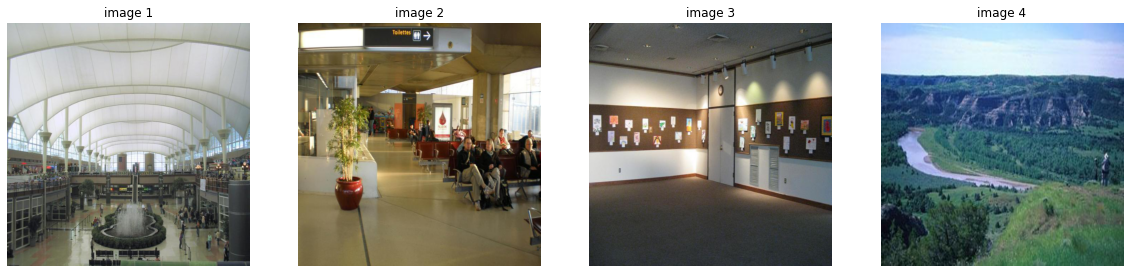

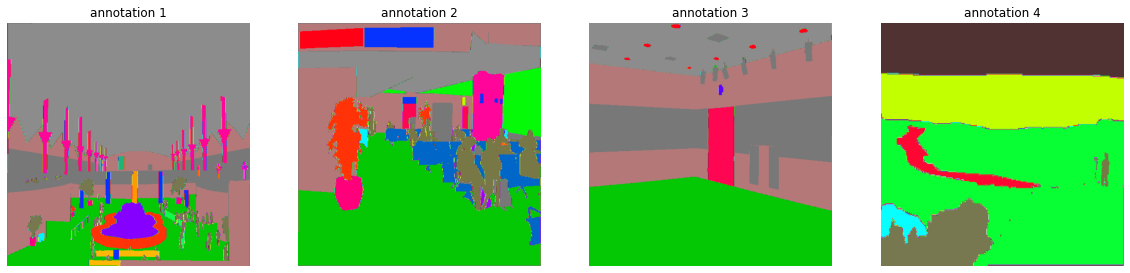

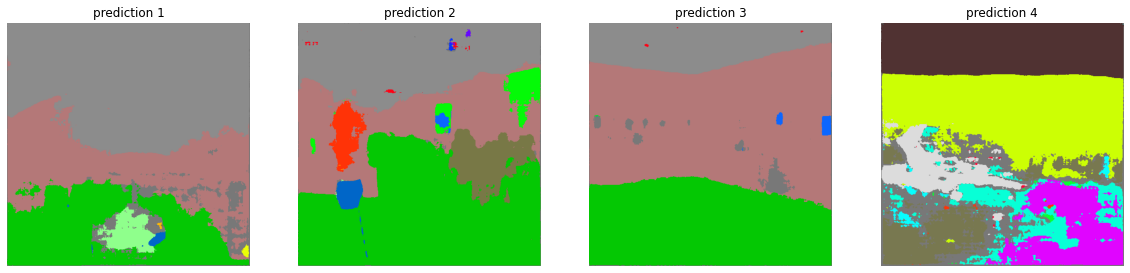

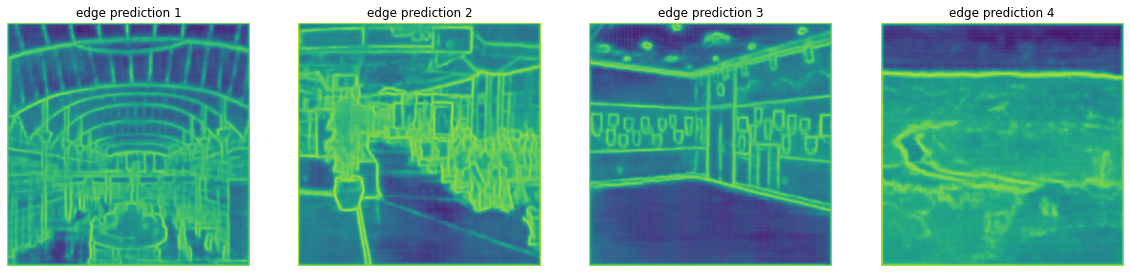

In [ ]:

def visualize_first_n(batch_img, batch_seg, n):
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    # break when no more axes left
    if ax is None:
        break
    ax.imshow(batch_img[i,:,:,:].permute((1,2,0)))
    ax.axis('off')
    ax.set_title('image {}'.format(i+1))
    i += 1
  plt.savefig("pre_img.png")

  fig, ax = plt.subplots(1, n, figsize=(20,10))
  i=0
  for ax in ax.ravel():
    if ax is None:
        break
    seg_mask = np.zeros((512,512,3))
    for k in range(512):
      for j  in range(512):
        seg_mask[k,j,:] = Mask[batch_seg[i,k,j].item()]/255.0
    ax.imshow(seg_mask)
    ax.axis('off')
    ax.set_title('annotation {}'.format(i+1))
    i += 1
  plt.savefig("pre_seg.png")

def visualize_prediction_edge_n(batch_img, batch_seg, n, model):
  model.eval()
  visualize_first_n(batch_img,batch_seg,n)
  fig, ax = plt.subplots(1, n, figsize=(20,10))
  model.eval()
  with torch.no_grad():
    prediction_raw, edge_raw = model(batch_img.to(device))
    prediction = np.argmax(prediction_raw.cpu(), axis = 1)
    edge_pred = torch.detach(edge_raw).cpu().numpy()
    ax = ax.ravel()
    for i in range(n):
      pre_mask = np.zeros((512,512,3))
      for k in range(512):
        for j  in range(512):
          pre_mask[k,j,:] = Mask[prediction[i,k,j].item()]/255.0
      ax[i].imshow(pre_mask)
      ax[i].axis('off')
      ax[i].set_title('prediction {}'.format(i+1))
    plt.savefig("pre_pred.png")

    fig, ax = plt.subplots(1, n, figsize=(20,10))
    ax = ax.ravel()
    for i in range(n):
      ax[i].imshow(edge_pred[i, 0, :, :])
      ax[i].axis('off')
      ax[i].set_title('edge prediction {}'.format(i+1))
    plt.savefig("pre_edge.png")
     

img, mask, edge = next(iter(test_data_loader))
visualize_prediction_edge_n(img, mask, 4, model)


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

In [ ]:
def intersectionAndUnion(imPred, imLab, numClass):
    imPred = np.asarray(imPred).copy()
    imLab = np.asarray(imLab).copy()

    imPred += 1
    imLab += 1
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab > 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(
        intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection

    return (area_intersection, area_union)
     

In [ ]:
fileobj = open("drive/My Drive/DL/objectInfo150.txt")
line = fileobj.readline()
weightclass = [0.0725]
line = fileobj.readline()
while line: 
    for i in range(len(line)):
        if line[i] == "\t":
            tmp = line[i+1:i+7]
            weight_i = float(tmp)
            weightclass.append(weight_i)
            break            
    line = fileobj.readline()
weightclass = np.array(weightclass)

In [ ]:
def accuracy(preds, label):
    valid = (label >= 0)
    acc_sum = (valid * (preds == label)).sum()
    valid_sum = valid.sum()
    acc = float(acc_sum) / (valid_sum + 1e-10)
    return acc, valid_sum
def evaluate(segmentation_module, loader, weightclass):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    intersection_meter_50 = AverageMeter()
    union_meter_50 = AverageMeter()

    segmentation_module.eval()

    for img, seg, edge in tqdm(validation_data_loader):
        # get the prediction here
        pred, edge = segmentation_module(img.to(device))
        pred = pred.detach().cpu()
        pred = np.argmax(pred, axis = 1)

        # calculate accuracy
        acc, pix = accuracy(pred, seg)
        intersection, union = intersectionAndUnion(pred, seg, 151)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)
        intersection_meter_50.update(intersection[0:50])
        union_meter_50.update(union[0:50])


    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    iou_50 = intersection_meter_50.sum / (union_meter_50.sum + 1e-10)
    wiou = weightclass*np.array(iou)
    f= open("drive/My Drive/DL/latest_model_A/iou_baseline.txt","w+")
    for i, _iou in enumerate(iou):
      print('class [{}], IoU: {:.4f}'.format(i, _iou))
      f.write('{}, {:.4f}'.format(i, _iou))
      f.write('\n')

    f.write('[Eval Summary]:')
    f.write('Mean IoU: {:.4f}, Mean IoU first 50 classes: {:.4f}, Weighted IoU: {:.4f}, Accuracy: {:.4f}%'
          .format(iou.mean(), iou_50.mean(), np.sum(wiou), acc_meter.average()*100))

evaluate(model, test_data_loader, weightclass)